# Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from bs4 import BeautifulSoup
import torch

import re, glob, gc

import logging
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/MicheleOrlandi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-11-06 12:55:05.449125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Advanced Sentiment Analysis using BERT model

Following instructions from [THIS](https://github.com/ipuneetrathore/BERT_models/blob/master/Running%20finBERT%20-%20How%20To.ipynb) link.

In [2]:
def get_clean_text(file_contents):
    """
    Function to clean text as taken by Agam Shah's Lecture
    """

    # remove new line characters
    text = re.sub(r'(\r\n|\n|\r)', ' ', file_contents) # \r new line in macOS, \n in Unix and \r\n in Windows

    # remove certain text using regexp
    text = re.sub(r'<textUMENT>\s*<TYPE>(?:GRAPHIC|ZIP|EXCEL|PDF|XML|JSON).*?</textUMENT>', ' ', text)
    text = re.sub(r'<SEC-HEADER>.*?</SEC-HEADER>', ' ', text)
    text = re.sub(r'<IMS-HEADER>.*?</IMS-HEADER>', ' ', text)

    # replace characters
    text = re.sub(r'&nbsp;', ' ', text)
    text = re.sub(r'&#160;', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&#38;', '&', text)

    # replace other encoded characters to whitespace
    text = re.sub(r'&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', text)

    try:
        soup = BeautifulSoup(text, 'html.parser')

        for tag in soup.find_all('xbrl'):
            # don't remove if there is item detail
            fp_result = tag(text=re.compile(r'(?i)item\s*\d', re.IGNORECASE))
            event = len(fp_result)

            # otherwise remove
            if event == 0:
                # decompose() method removes a tag as well as its inner content
                tag.decompose()

        # remove tables
        for tag in soup.find_all('table'):
            temp = tag.get_text()
            numbers = sum(c.isdigit() for c in temp)
            letters = sum(c.isalpha() for c in temp)
            num_letter_ratio = 1.0
            if (numbers + letters) > 0:
                num_letter_ratio = numbers / (numbers + letters)

            event = 0
            if (event == 0) and (num_letter_ratio > 0.1):
                tag.decompose()

        # remove text that was used for styling
        text = soup.get_text()
        text = re.sub(r'<(?:ix|link|xbrli|xbrldi).*?>.*?<\/.*?>', ' ', text)

        # remove extra whitespace
        text = ''.join(line.strip() for line in text.split('\n'))

    except:
        # remove extra whitespace
        text = ''.join(line.strip() for line in text.split('\n'))

    # additional cleaning
    text = re.sub(r'--;', ' ', text)
    text = re.sub(r'__', ' ', text)

    # more cleaning
    cleaner = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = re.sub(cleaner, ' ', text)

    temp_match = re.search(r'^.*?item(\s)*\d', text, flags=re.IGNORECASE)
    if temp_match is not None:
        text = re.sub(r'^.*?item(\s)*\d', '', text, count=1, flags=re.IGNORECASE)

    # replace more than one whitespace with single whitespace
    text = re.sub(r'\s+', ' ', text)
    gc.collect();
    return text


In [4]:
## Download pretrained finBERT model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=torch.device('mps'), framework='pt', truncation=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def get_BERT_sentiment(dir_list):
    BERT_scores = []

    # class_labels = {'LABEL_0': 'neutral', 'LABEL_1': 'negative', 'LABEL_2': 'positive'}
    # results['label'] = results['label'].map(class_labels)

    # c = 0
    for file in dir_list:
        with open(file) as f:
            file_contents = f.read()

        # clean the text
        text = get_clean_text(file_contents)

        tone = pd.DataFrame(classifier(text)).mean()[0]
        BERT_scores.append((file, tone))

        # c += 1
        # if c % 100 == 0:
        #     print(f"Round {c} complete!")

    bert_df = pd.DataFrame(BERT_scores).set_axis(['FileName', 'BERTScore'], axis = 1, inplace = False)

    return bert_df

In [5]:
cols = [f'CAR_{i}' for i in range(6) if i != 4] + [f'CATO_{i}' for i in range(6) if i != 4] + [f'FAMA_CAR_{i}' for i in range(6) if i != 4] + ['quintile']
file_glob = glob.glob("data/SEC_8-K_records/*.txt")
temp_len = len("data/SEC_8-K_records/")

In [6]:
bert_scores_df = get_BERT_sentiment(dir_list=file_glob)

In [7]:
bert_scores_df['fyear'] = bert_scores_df['FileName'].str[temp_len:].apply(lambda x: x.split('_')[0]).astype(int)
bert_scores_df['cik'] = bert_scores_df['FileName'].str[temp_len:-4].apply(lambda x: x.split('_')[1]).astype(int)

In [8]:
def special_qcut(x):
    gc.collect();
    return pd.qcut(x.rank(method='first'), 5, labels=range(1, 6))

In [9]:
# sort scaled difference into quintiles at an annual frequency
bert_scores_df['quintile'] = bert_scores_df.groupby('fyear', group_keys=False)['BERTScore'].apply(special_qcut)
bert_scores_df.head()

,FileName,BERTScore,fyear,cik,quintile
0,data/SEC_8-K_records/1996_17843.txt,0.999975,1996,17843,1
1,data/SEC_8-K_records/2019_921582.txt,0.999991,2019,921582,2
2,data/SEC_8-K_records/2014_1308161.txt,0.999993,2014,1308161,5
3,data/SEC_8-K_records/2004_1109808.txt,0.999985,2004,1109808,1
4,data/SEC_8-K_records/2018_859737.txt,0.999992,2018,859737,3


## Merge and save dataset

In [10]:
ASR_df = pd.read_csv("ASR_df.csv", index_col=0)
bert_scores_df = bert_scores_df.merge(ASR_df, how='inner', left_on=['cik', 'fyear'], right_on=['cik', 'fyear'])

In [11]:
bert_scores_df.to_csv('bert_scores_df.csv')

In [12]:
bert_scores_df = pd.read_csv("bert_scores_df.csv", index_col=0)

In [20]:
bert_scores_df = bert_scores_df.loc[:, cols].copy(deep=True)
df_stats = bert_scores_df.groupby('quintile').describe()
df_stats.to_csv('bert_sentiment_stats.csv')
df_stats

CAR_0                                                    \
             count      mean       std       min       25%       50%   
quintile                                                               
1         762732.0  0.000097  0.034835 -0.664367 -0.011654 -0.000561   
2         848651.0 -0.000016  0.042521 -0.758341 -0.012258 -0.000805   
3         744388.0  0.000110  0.042983 -0.723535 -0.013179 -0.000876   
4         742315.0  0.000019  0.034894 -0.658385 -0.011649 -0.000652   
5         862170.0 -0.000187  0.039912 -0.717224 -0.011325 -0.000791   

                                 CAR_1            ... FAMA_CAR_3             \
               75%       max     count      mean  ...        75%        max   
quintile                                          ...                         
1         0.010625  1.721143  761168.0  0.000280  ...   0.060195   7.724838   
2         0.010558  3.428069  847132.0 -0.000085  ...   0.061623  18.683842   
3         0.011162  1.826377  742881.0  0.000331  ...   0.062977   7.504188   
4         0.010562  2.006533  740888.0  0.000038  ...   0.061375   5.520375   
5         0.009583  2.932224  860682.0 -0.000579  ...   0.056335   9.474322   

         FAMA_CAR_5                                                    \
              count      mean       std       min       25%       50%   
quintile                                                                
1          756562.0  0.001531  0.276414 -7.203019 -0.093331 -0.003517   
2          842776.0  0.001231  0.363633 -6.307351 -0.101974 -0.006116   
3          738293.0  0.002936  0.382312 -5.689419 -0.104476 -0.006417   
4          736367.0 -0.000157  0.273050 -6.944928 -0.095159 -0.004110   
5          854388.0 -0.000793  0.350695 -5.310199 -0.093170 -0.005468   

                               
               75%        max  
quintile                       
1         0.087226   9.355318  
2         0.089698  29.360323  
3         0.090469  11.792295  
4         0.088518   6.511578  
5         0.081732  14.880036  

[5 rows x 120 columns]

## Distribution for each Quintile

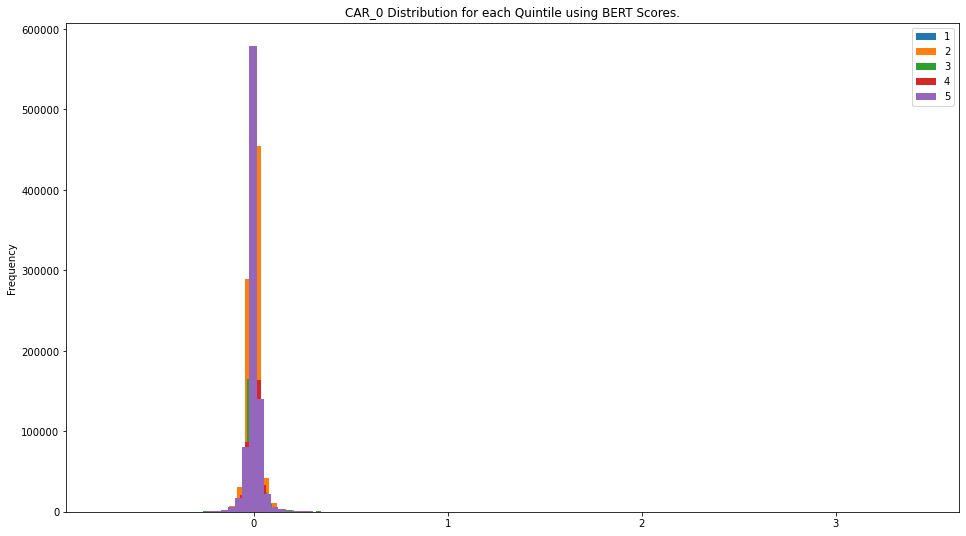

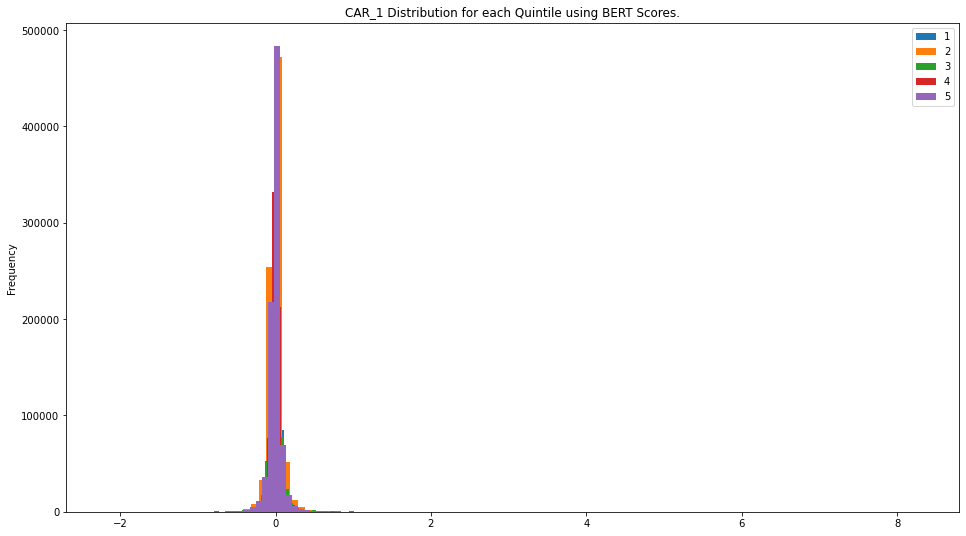

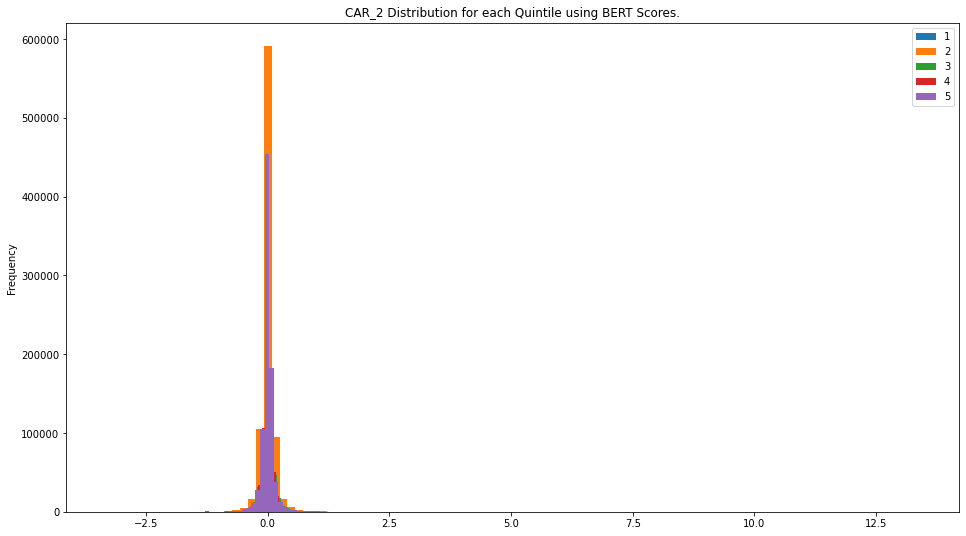

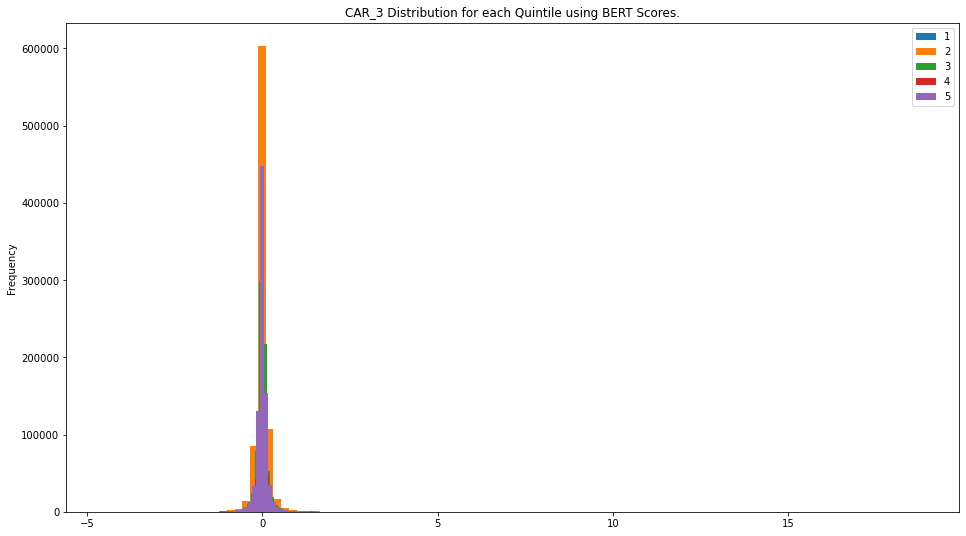

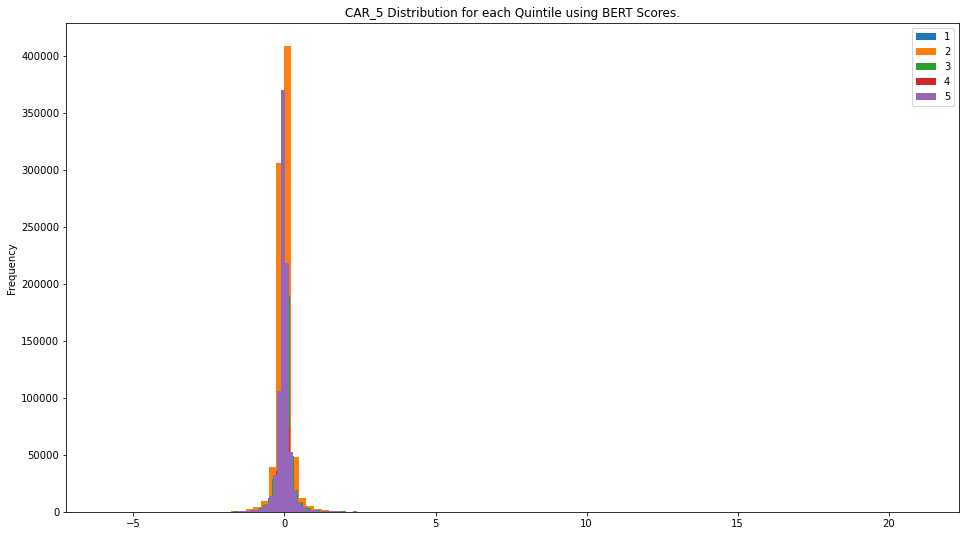

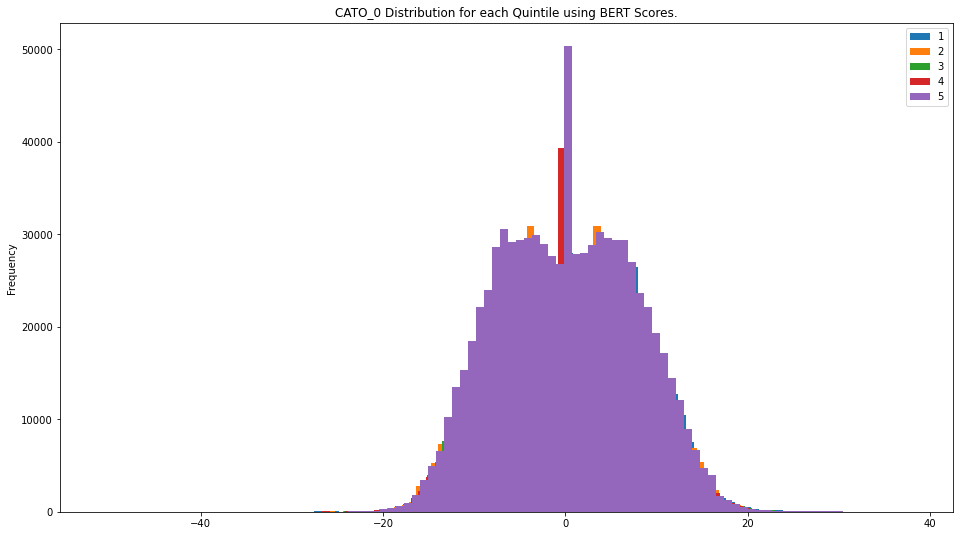

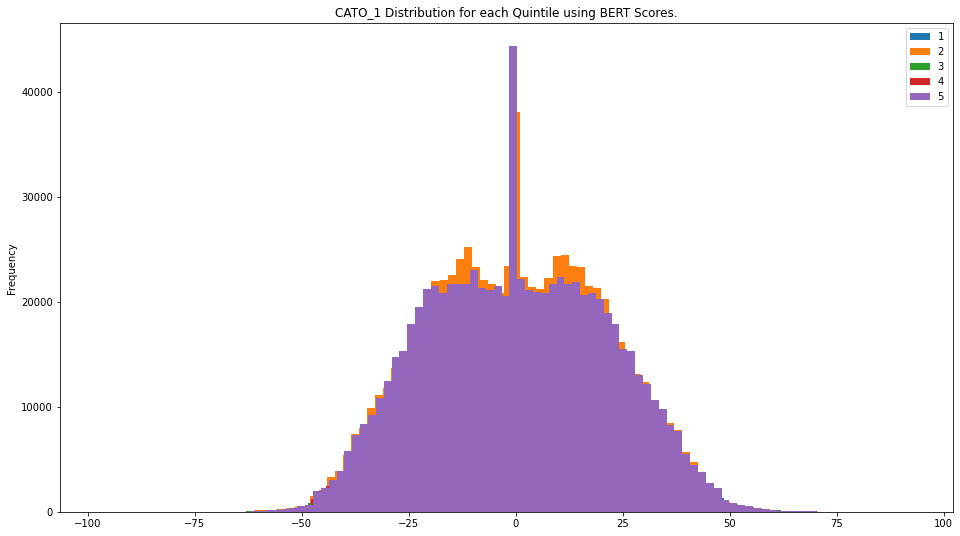

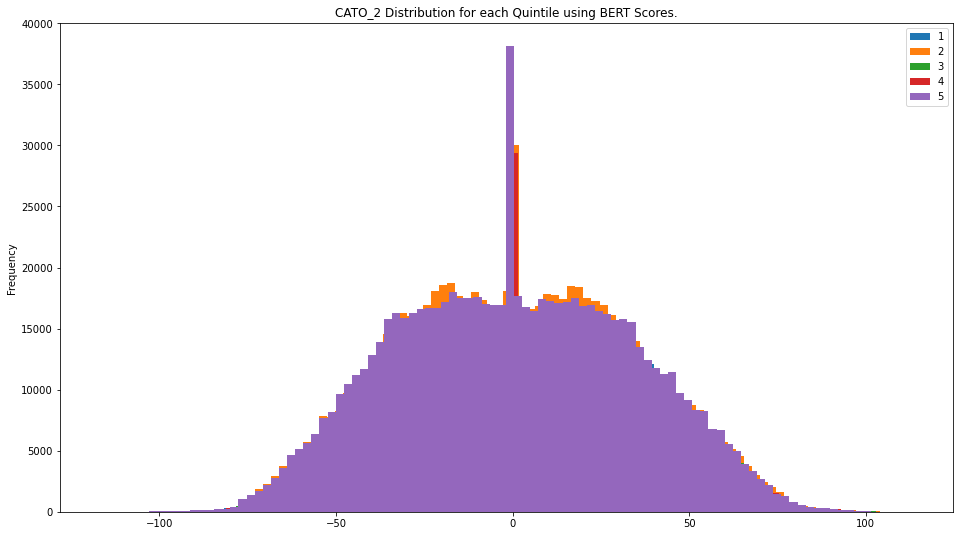

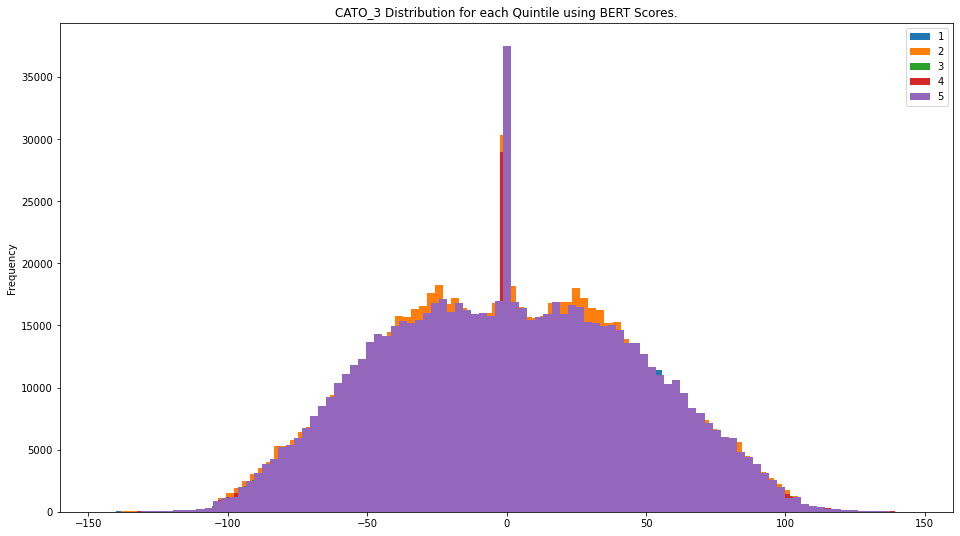

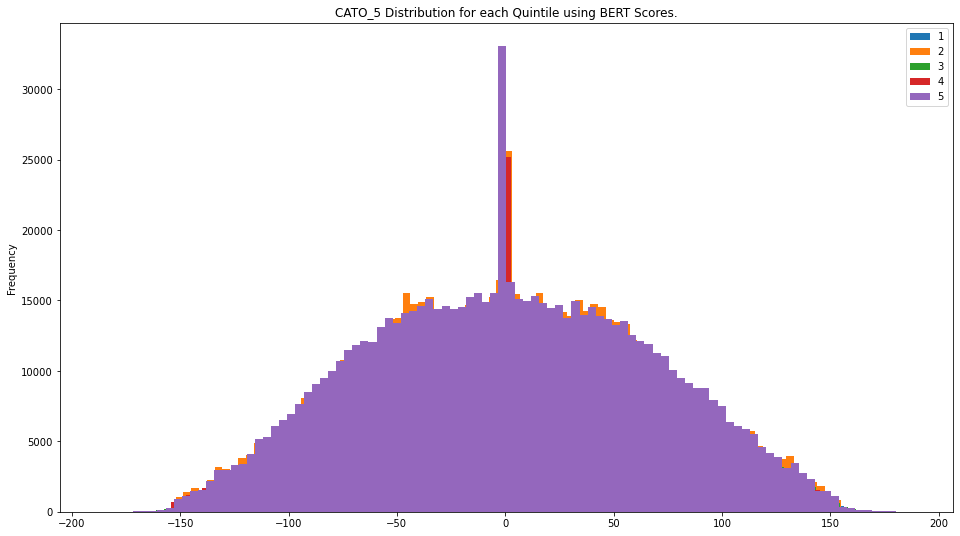

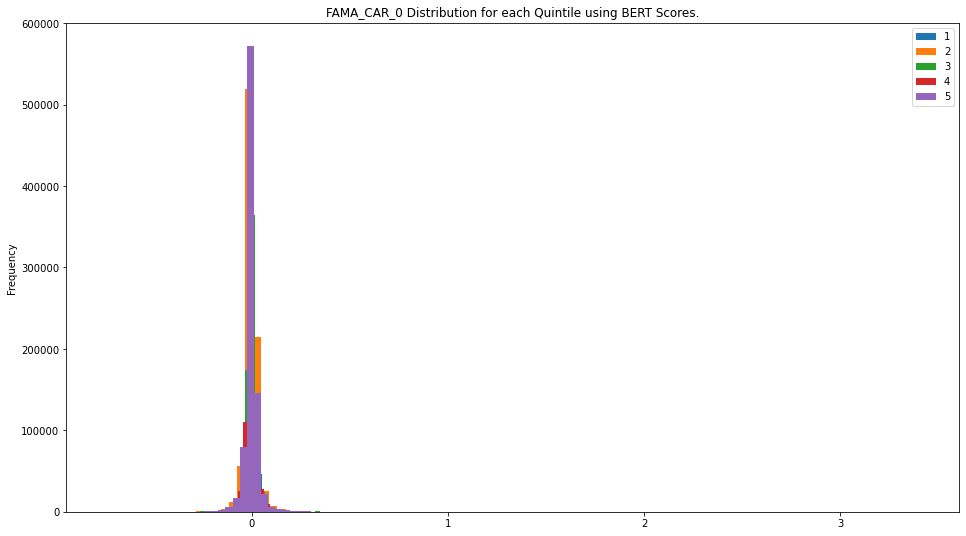

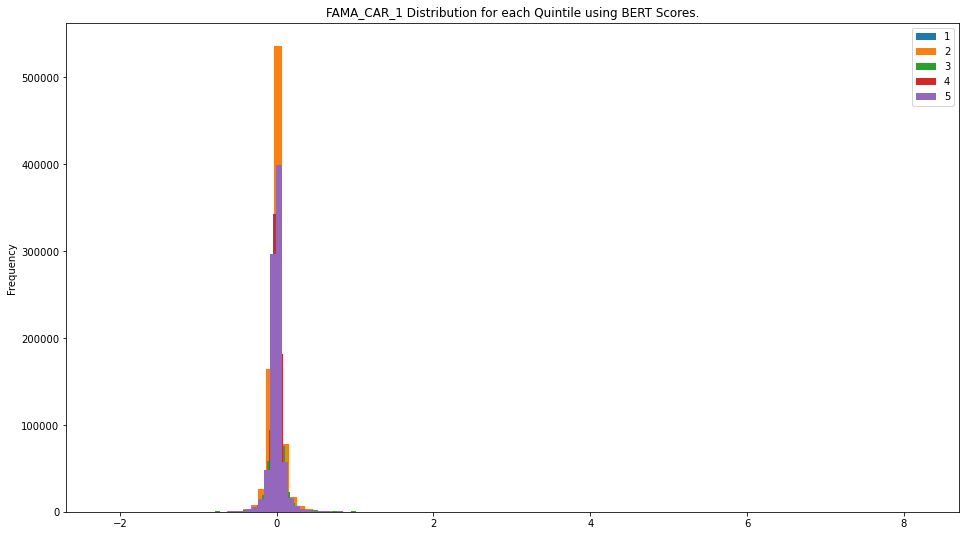

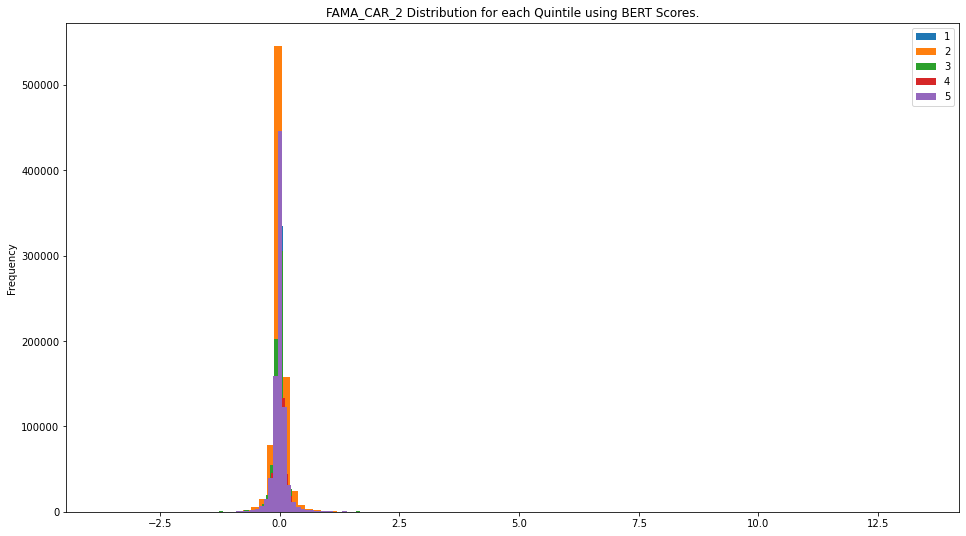

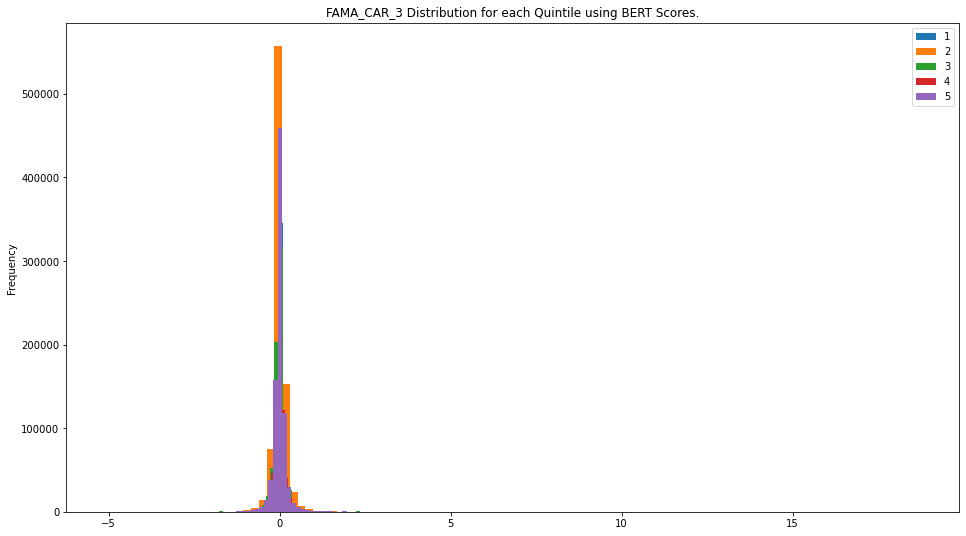

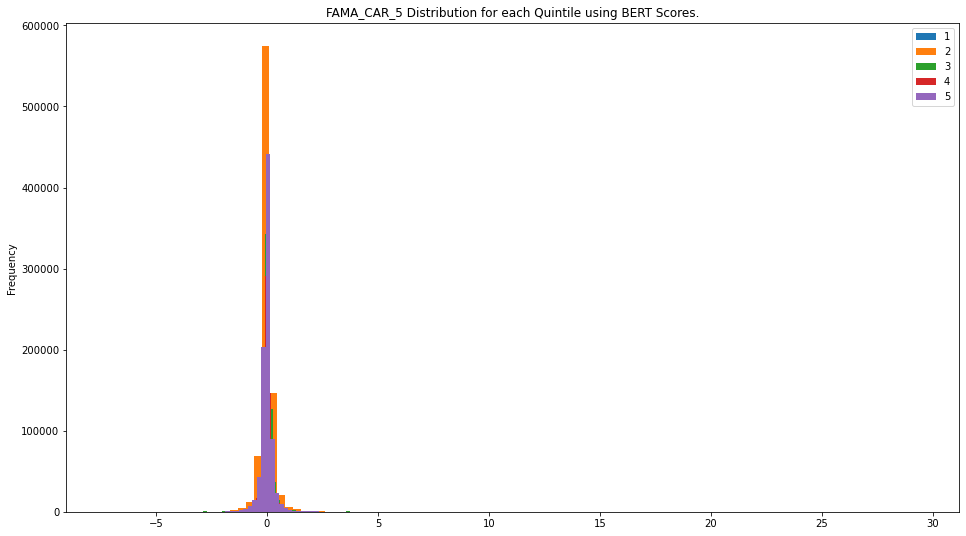

In [13]:
for i, col in enumerate(cols[:-1]):
    gc.collect();
    plt.figure(figsize=(16, 9))
    bert_scores_df.groupby('quintile')[col].plot(kind='hist', legend=True, bins=100, title=f"{col} Distribution for each Quintile using BERT Scores.")
    plt.show()